<a href="https://colab.research.google.com/github/velblu/Tokyo-Stock-Exchange-Predictions/blob/main/jpx_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Task description
This is an attempt to create technical classificator based only on technical values like OHLCV. No fundamental information are taken into consideration (like business sectors or financial results). 

Classificator should point to buy (long position) or do nothing on next day morning (on open). We expect that in next 5 days stock price will go up for 2% or more on close.

Target value is based on next day open value and max from next 5 days close values: (max(next 5 Close) - Open) / Open, if:
- return < 2%     then None
- 2% <= return       then Long

There is a target data in dataset but new target data will be created.

Original data comes from: 
https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction

# B. Prerequisitions
Importing right packages..

In [1]:
# basics
import pandas
import pandas as pd
import numpy as np
import re
import pickle
# from datetime import datetime

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, \
                            roc_auc_score, f1_score, precision_score, \
                            recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, \
                                    KFold, StratifiedKFold

#xgboost
from xgboost import XGBClassifier

#hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, partial

# drawings
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

.. and downloading dataset

In [2]:
# downloading file with data (was to big for github)
!gdown --id 10ROR3xkve2Xr0mAoOiZoa-3p490LEwZt

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10ROR3xkve2Xr0mAoOiZoa-3p490LEwZt
To: /content/stock_prices.csv
100% 218M/218M [00:00<00:00, 299MB/s]


# C. Data preparation
In this part data will be loaded and analysed. Transformers will be build and tested.

## 1. Loading dataset 

In [3]:
# preparing function to load dataset
def load_dataset(folder_name: str, file_name: str, index_col: list = None) -> pandas.DataFrame:
    """
    Loading dataset. 

    :param folder_name: Folders path to file with data    
    :param file_name: Name of file 
    :param index_col: List of columns that are indexes
    :return: Dataframe with dataset
    """
    dataset = pd.read_csv(f'{file_name}', index_col=index_col)
    return dataset


In [4]:
FOLDER: str = ''
FILE: str = 'stock_prices.csv'
INDEX: list = []

# Loading dataset with prices and volumes (and other)
data = load_dataset(FOLDER, FILE, INDEX)
data.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [5]:
# housekeeping .. 
del FILE
del FOLDER
del INDEX
del STATUS_OK

## 2. Dataset specification
High level analysis to understand the data with little summary on the end. 
But first lets check data types..


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


Looks like most of data are numbers. Only RowId and Date are objects. 

### 2.1 SecuritiesCode 
- description: local securities code
- type: Int64
- sample value: 1301

In [7]:
# description of this data
data['SecuritiesCode'].describe().apply("{0:.1f}".format)

count    2332531.0
mean        5894.8
std         2404.2
min         1301.0
25%         3891.0
50%         6238.0
75%         7965.0
max         9997.0
Name: SecuritiesCode, dtype: object

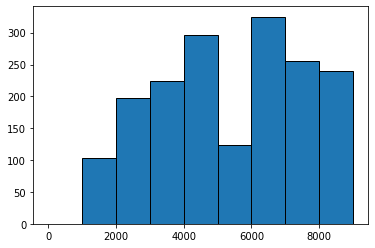

In [8]:
# securieties codes list
securieties_codes: list = list(data['SecuritiesCode'].unique())

plt.hist(securieties_codes, bins=range(0, 10000, 1000), edgecolor='black')
plt.show()

This is a column with securities id's and will be used as index.
- minimal value is 1301
- maximum value is 9997

In [9]:
# setting as index
data.set_index(keys=['SecuritiesCode'], inplace=True)
data.head()

,RowId,Date,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
SecuritiesCode,,,,,,,,,,,
1301,20170104_1301,2017-01-04,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1332,20170104_1332,2017-01-04,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1333,20170104_1333,2017-01-04,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
1376,20170104_1376,2017-01-04,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
1377,20170104_1377,2017-01-04,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


### 2.2 Date

- description: trade date
- type: date
- sample value: 2017-01-04 0:00:00


In [10]:
# describing column
pd.to_datetime(data['Date']).describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                 2332531
unique                   1202
top       2021-12-03 00:00:00
freq                     2000
first     2017-01-04 00:00:00
last      2021-12-03 00:00:00
Name: Date, dtype: object

In [11]:
# checking days of week
pd.to_datetime(data['Date']).dt.day_name().unique()

array(['Wednesday', 'Thursday', 'Friday', 'Tuesday', 'Monday'],
      dtype=object)

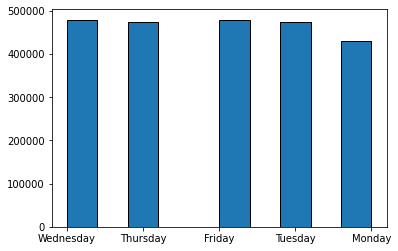

In [12]:
# days of week histogram
plt.hist(pd.to_datetime(data['Date']).dt.day_name(), 
         edgecolor='black')
plt.show()

This is column with trade dates and it will be used as index. 
- Dates starts from 2017-01-04 and finishes at 2021-12-03. 
- Dates are only monday - friday days of week 
- There is even distribution of data by days of week

In [13]:
# setting as index
data.set_index(keys=['Date'], append=True, inplace=True)
data.head()

,,RowId,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
SecuritiesCode,Date,,,,,,,,,,
1301,2017-01-04,20170104_1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1332,2017-01-04,20170104_1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1333,2017-01-04,20170104_1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
1376,2017-01-04,20170104_1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
1377,2017-01-04,20170104_1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


### 2.3 RowID
- description: unique ID of price records
- type: string 
- sample value: 20170104_1301

In [14]:
# description of this data
data['RowId'].describe()

count           2332531
unique          2332531
top       20170104_1301
freq                  1
Name: RowId, dtype: object

In [15]:
# counting nulls 
data['RowId'].isnull().sum()

0

In [16]:
# how does structure of row id looks like? 
data['RowId'][:10]

SecuritiesCode  Date      
1301            2017-01-04    20170104_1301
1332            2017-01-04    20170104_1332
1333            2017-01-04    20170104_1333
1376            2017-01-04    20170104_1376
1377            2017-01-04    20170104_1377
1379            2017-01-04    20170104_1379
1381            2017-01-04    20170104_1381
1407            2017-01-04    20170104_1407
1414            2017-01-04    20170104_1414
1417            2017-01-04    20170104_1417
Name: RowId, dtype: object

This is column is an id for a row and brings no value for us. Will be deleted
- one row id occurs only ones
- there are no null values
- structure of this data: YYYYMMDD_SecurietiesCode

In [17]:
# adding to remove 
prepering_data_remove_columns: list = ['RowId']

### 2.4 OHLC

Open:
- description: first traded price on a day
- type: float
- sample value: 2734

High:
- description: highest traded price on a day
- type: float
- sample value: 2755

Low: 
- description: lowest traded price on a day
- type: float
- sample value: 2730

Close:
- description: last traded price on a day
- type: float
- sample value: 2742

In [18]:
# description of this data
data[['Open', 'High', 'Low', 'Close']].describe().applymap("{0:.1f}".format)

,Open,High,Low,Close
count,2324923.0,2324923.0,2324923.0,2324923.0
mean,2594.5,2626.5,2561.2,2594.0
std,3577.2,3619.4,3533.5,3576.5
min,14.0,15.0,13.0,14.0
25%,1022.0,1035.0,1009.0,1022.0
50%,1812.0,1834.0,1790.0,1811.0
75%,3030.0,3070.0,2995.0,3030.0
max,109950.0,110500.0,107200.0,109550.0


In [19]:
# securieties codes list cut to first ten securieties
securieties_codes_head: list = securieties_codes[:10]

fig = go.Figure()

# creating traces for figure - candelstick figures for selected securieties
for securities_code in securieties_codes_head:
  fig.add_trace(
      go.Candlestick(x=data.loc[securities_code].index,
                     open=data.loc[securities_code]['Open'],
                     high=data.loc[securities_code]['High'],
                     low=data.loc[securities_code]['Low'],
                     close=data.loc[securities_code]['Close'])
  )

button_all: list = [dict(label = f'All_{len(securieties_codes_head)}',
                  method = 'update',
                  args = [{'visible': [True for sec_code in securieties_codes_head],
                            'title': 'All',
                            'showlegend':False}]),]

def create_securieties_button(securieties_code: int) -> dict:
  """
  Creates single button description for securieties menu.
  
  :param X: Securieties code
  :return: Single button description
  :
  """
  return dict(label=str(securieties_code),
              method='update',
              args=[{'visible': [sec_code == securieties_code 
                                 for sec_code in securieties_codes_head],
                     'title': str(securieties_code),
                     'showlegend': False}])

# buttons list (with 'all values' button)
buttons: list  = [create_securieties_button(sec_code) 
                    for sec_code in securieties_codes_head]
all_buttons: list = button_all + buttons

# adding menu to plot
fig.update_layout(title='Selected securieties codes charts',
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons= all_buttons
)])

fig.show()

In [20]:
# checking if nulls in OHLC occurs always in all OHLC at ones

# df with rowids
ohlc_nulls = data['RowId'].to_frame()

# how many rows with null values in all OHLC at ones
ohlc_nulls['all'] = data[['Open', 'High', 'Low', 'Close']].isna().all(axis=1)

# how many rows where null values is in only one OHLC
ohlc_nulls['any'] = data[['Open', 'High', 'Low', 'Close']].isna().any(axis=1)

# for which RowIds nulls in any of OHLC do not overlap nulls witk all of OHLC
ohlc_nulls['RowId'][ohlc_nulls['any'] != ohlc_nulls['all']]
# there are non that kind of rows

Series([], Name: RowId, dtype: object)

In [21]:
# dates were all securieties do not have OHLC values 
# series of dates where all securieties count == securieties with all nulls in OHLC
ohlc_nulls_all=ohlc_nulls['RowId'].groupby(['Date']).count() == ohlc_nulls['all'].groupby(['Date']).sum()

# dates where this occured
ohlc_nulls_all[ohlc_nulls_all]

#there were only one date like that
# https://www.jpx.co.jp/english/corporate/news/news-releases/0060/20201019-01.html

Date
2020-10-01    True
dtype: bool

This columns are main information for our analysis. Rows with null should be removed.
- representing stock values in day period 
- are variety of float values 
- in time dimension creates stock chart 
- null values occur only for all OHLC values at once 
- one day (2020-10-01 ) jpx was off https://www.jpx.co.jp/english/corporate/news/news-releases/0060/20201019-01.html 

### 2.5 Volume 
- description: number of traded stocks on a day
- type: Int64
- sample value: 31400

In [22]:
# description of this data
data['Volume'].describe().apply("{0:.1f}".format)

count      2332531.0
mean        691936.6
std        3911255.9
min              0.0
25%          30300.0
50%         107100.0
75%         402100.0
max      643654000.0
Name: Volume, dtype: object

In [23]:
# how many null values
data['Volume'].isna().sum()

0

In [24]:
# when null values occur
ohlc_nulls['volume'] = data['Volume'] == 0

# checking if ohlc is null then volume != 0 ? 
ohlc_nulls['RowId'][ohlc_nulls['all'] != ohlc_nulls['volume']]

# in all row_ids (data-securieties): 
# when OHLC is null =>  volume == 0 
# or 
# when OHLC is not null => volume != 0

Series([], Name: RowId, dtype: object)

This column gives main information for our analysis as well. Rows should be removed when OHLC values are nulls.
- there is variety of values in this column
- there are no null values
- when all OHLC are null => volume == 0 
- when OHLC values are not null => volume > 0


### 2.6 AdjustmentFactor
- description: to calculate theoretical price/volume when split reverse-split happens (NOT including dividend/allotment of shares/)
- type: float
- sample value: 1

In [25]:
# how many different values?
data['AdjustmentFactor'].value_counts(dropna=False)

1.000000     2331801
0.500000         328
5.000000         113
10.000000        103
0.333333          59
2.000000          36
0.250000          33
0.200000          20
0.909091          10
0.833333           6
0.769231           6
0.666667           4
0.100000           3
0.952381           3
0.800000           2
0.142857           1
0.869565           1
4.000000           1
20.000000          1
Name: AdjustmentFactor, dtype: int64

In [26]:
# number of rows where no merge/split were done
data['AdjustmentFactor'][data['AdjustmentFactor'] == 1].count()
print('#:', data['AdjustmentFactor'][data['AdjustmentFactor'] == 1].count())
print('%:', (data['AdjustmentFactor'][data['AdjustmentFactor'] == 1].count() / 
      data['AdjustmentFactor'].count())*100)

#: 2331801
%: 99.96870352419754


In [27]:
# how many merge actions where done 
print('#:', data['AdjustmentFactor'][data['AdjustmentFactor'] > 1].count())
print('%:', (data['AdjustmentFactor'][data['AdjustmentFactor'] > 1].count() / 
      data['AdjustmentFactor'].count())*100)

#: 254
%: 0.01088945870387146


In [28]:
# how many split actions where done 
print('#:', data['AdjustmentFactor'][data['AdjustmentFactor'] < 1].count())
print('%:', (data['AdjustmentFactor'][data['AdjustmentFactor'] < 1].count() / 
      data['AdjustmentFactor'].count())*100)

#: 476
%: 0.020407017098593758


It will not influence our analysis because we are analysing only difference between Open and Close value in this same day. Will information that split/merge happen be useful? I think not.
- there are no nulls 
- there where 476 splits (0,02% of all)
- there where 254 merges (0,01% of all) 

### 2.7 SupervisionFlag 
- description: "Flag of Securities Under Supervision & Securities to Be Delisted
https://www.jpx.co.jp/english/listing/market-alerts/supervision/00-archives/index.html )"
- type: boolean
- sample value: FALSE



In [29]:
# how many null values?
data['SupervisionFlag'].isnull().sum()

0

In [30]:
# number of rows
data['SupervisionFlag'].value_counts(dropna=False, normalize=False)

False    2332001
True         530
Name: SupervisionFlag, dtype: int64

In [31]:
# percentage of rows
data['SupervisionFlag'].value_counts(dropna=False, normalize=True)

False    0.999773
True     0.000227
Name: SupervisionFlag, dtype: float64

Low number of situations where stocks where under supervisioning. This information will not be usefull.
- there are no nulls 
- there where 530 cases like that (0,02% of all) 
- need to be changed to categorical type

### 2.8 ExpectedDividend 
- description: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.
- type: float
- sample value:

In [32]:
# number of rows
data['ExpectedDividend'].value_counts(dropna=False, normalize=False)

NaN       2313666
0.00         3551
10.00         901
20.00         838
15.00         797
           ...   
18.80           1
26.22           1
325.00          1
56.60           1
16.37           1
Name: ExpectedDividend, Length: 447, dtype: int64

In [33]:
# number of cases like that
data['ExpectedDividend'].count()

18865

This columns is mostly nulls but it can be useful in this attempt. 

### 2.9 Target 
- description: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is TradeDate
- type: float
- sample value: 0.00073

New target column will have to be created. This one is inconsistent with the goals of our attempt. 

In [34]:
# adding to delete
prepering_data_remove_columns.append('Target')
prepering_data_remove_columns

['RowId', 'Target']

### 2.10 Housekeeping.. 

In [35]:
del all_buttons, button_all, buttons
del fig
del ohlc_nulls, ohlc_nulls_all
del securieties_codes, securieties_codes_head, securities_code

## 3. Transformers for data preparation
Building and testing transformers for data preparation section. 

In [36]:
# copying data for testing purposes
test_data = data.copy()

### 3.1 DeleteRowsWithNulls 

In [37]:
class DeleteRowsWithNulls(BaseEstimator, TransformerMixin):
    """
    Transformer removing rows with null values (all/any) in specified columns.

    :param subset: List of columns where null values will be searched for, if None then all columns will be used.
    :param how: Determine if row or column is removed from DataFrame, when we have at least one NA or all NA.
    """
    how: str
    subset: list

    def __init__(self, subset: list = None, how: str = 'all'):
        self.subset = subset
        self.how = how

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Set which column should be considered if None was given. 
        And then remove rows with nulls.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Transformed input (with deleted rows).
        """
        if self.subset is None:
            self.subset = X.columns.tolist()
        return X.dropna(subset=self.subset, how=self.how)

In [38]:
# removing rows where all OHLC values are nulls 
test_transformer = DeleteRowsWithNulls(subset=['Open', 'High', 'Low', 'Close'], how='all')
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.isna().sum()

RowId                     0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2306082
SupervisionFlag           0
Target                    0
dtype: int64

### 3.2 SortData

In [39]:
class SortData(BaseEstimator, TransformerMixin):
    """
    Transformer which sort data by columns (ascending).

    :param by: List of columns by which sorting is done
    :param axis: Axis to be sorted.
    """
    by: list
    axis: str

    def __init__(self, by: list = None, axis: str = 'index'):
        self.by = by
        self.axis = axis

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """

        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Set by which names sorting will be done if None were given in params.
        And then sort data by names

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Sorted input.
        """
        if self.by is None:
            self.by = list(X.index.names)
        return X.sort_values(by=self.by, axis=self.axis, ascending=True, inplace=False)

In [40]:
# sorting data by index
test_transformer = SortData(by=['SecuritiesCode', 'Date'])
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

RowId    Open    High     Low   Close  \
SecuritiesCode Date                                                        
1301           2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   
               2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   
               2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   
               2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   
               2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0   
...                                  ...     ...     ...     ...     ...   
9997           2021-11-29  20211129_9997   678.0   679.0   665.0   668.0   
               2021-11-30  20211130_9997   670.0   689.0   667.0   667.0   
               2021-12-01  20211201_9997   661.0   688.0   660.0   685.0   
               2021-12-02  20211202_9997   681.0   692.0   680.0   684.0   
               2021-12-03  20211203_9997   690.0   711.0   686.0   696.0   

                           Volume  AdjustmentFactor  ExpectedDividend  \
SecuritiesCode Date                                                     
1301           2017-01-04   31400               1.0               NaN   
               2017-01-05   17900               1.0               NaN   
               2017-01-06   19900               1.0               NaN   
               2017-01-10   24200               1.0               NaN   
               2017-01-11    9300               1.0               NaN   
...                           ...               ...               ...   
9997           2021-11-29  320800               1.0               NaN   
               2021-11-30  296300               1.0               NaN   
               2021-12-01  339100               1.0               NaN   
               2021-12-02  342900               1.0               NaN   
               2021-12-03  381100               1.0               NaN   

                           SupervisionFlag    Target  
SecuritiesCode Date                                   
1301           2017-01-04            False  0.000730  
               2017-01-05            False  0.002920  
               2017-01-06            False -0.001092  
               2017-01-10            False -0.005100  
               2017-01-11            False -0.003295  
...                                    ...       ...  
9997           2021-11-29            False  0.026987  
               2021-11-30            False -0.001460  
               2021-12-01            False  0.017544  
               2021-12-02            False  0.014368  
               2021-12-03            False  0.018414  

[2324923 rows x 10 columns]

### 3.3 AddNewClassification

In [41]:
class AddNewClassification(BaseEstimator, TransformerMixin):
    """
    Transformer which adds new target data (as column) based on next day Open 
    and next 5 days Close values.

    * result < 0.02    => None
    * 0.02 <= result   => Long
    """
    new_col_name: str

    def __init__(self, new_col_name='Class'):

        self.new_col_name = new_col_name

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating and categorizing new target values.
        And then adding column with new classificator.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with new classificator as new column.
        """

        def categorize_result(result) -> int:
            """
            Change numerical value to categorical value.

            :param result: Numerical value for new target
            :return: Categorical value for new target
            """
            if result < 0.02:
                return 'None'
            else:
                return 'Long'

        # take only open and close values
        df = X[['Close', 'Open']].copy()

        # max close value from next 5 days (without today)
        # reverse order and grouped 
        # without today 
        # max value from next 5 days 
        df['close_max5'] = df[::-1].groupby('SecuritiesCode') \
                                   .shift(1) \
                                   .rolling(5)['Close'] \
                                   .max() 

        # next day open value
        df['open1'] = df['Open'].shift(-1)
        df['result'] = (df['close_max5'] - df['open1']) / df['open1']

        # print(df)

        new_target = (df['close_max5'] - df['open1']) / df['open1']

        # self.new_target = self.new_target.apply(categorize_result).groupby('SecuritiesCode').shift(-1).astype('category')
        new_target = new_target.apply(categorize_result).astype('category')
        new_target.rename('Class', inplace=True)

        X_out: pandas.DataFrame = X.copy()
        return X_out.join(new_target)

In [42]:
# creating new classification 
test_transformer = AddNewClassification()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

RowId    Open    High     Low   Close  \
SecuritiesCode Date                                                        
1301           2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   
               2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   
               2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   
               2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   
               2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0   
...                                  ...     ...     ...     ...     ...   
9997           2021-11-29  20211129_9997   678.0   679.0   665.0   668.0   
               2021-11-30  20211130_9997   670.0   689.0   667.0   667.0   
               2021-12-01  20211201_9997   661.0   688.0   660.0   685.0   
               2021-12-02  20211202_9997   681.0   692.0   680.0   684.0   
               2021-12-03  20211203_9997   690.0   711.0   686.0   696.0   

                           Volume  AdjustmentFactor  ExpectedDividend  \
SecuritiesCode Date                                                     
1301           2017-01-04   31400               1.0               NaN   
               2017-01-05   17900               1.0               NaN   
               2017-01-06   19900               1.0               NaN   
               2017-01-10   24200               1.0               NaN   
               2017-01-11    9300               1.0               NaN   
...                           ...               ...               ...   
9997           2021-11-29  320800               1.0               NaN   
               2021-11-30  296300               1.0               NaN   
               2021-12-01  339100               1.0               NaN   
               2021-12-02  342900               1.0               NaN   
               2021-12-03  381100               1.0               NaN   

                           SupervisionFlag    Target Class  
SecuritiesCode Date                                         
1301           2017-01-04            False  0.000730  None  
               2017-01-05            False  0.002920  None  
               2017-01-06            False -0.001092  None  
               2017-01-10            False -0.005100  None  
               2017-01-11            False -0.003295  None  
...                                    ...       ...   ...  
9997           2021-11-29            False  0.026987  Long  
               2021-11-30            False -0.001460  Long  
               2021-12-01            False  0.017544  Long  
               2021-12-02            False  0.014368  Long  
               2021-12-03            False  0.018414  Long  

[2324923 rows x 11 columns]

In [43]:
test_data['Class'].value_counts()

None    1366986
Long     957937
Name: Class, dtype: int64

### 3.4 DropColumns

In [44]:
class DropColumns(BaseEstimator, TransformerMixin):
    """
    Transformer to drop specified columns.
    """
    cols_to_drop: list

    def __init__(self, cols_to_drop: list = None):
        self.cols_to_drop = cols_to_drop

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Dropping columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with dropped columns.
        """
        if self.cols_to_drop is None:
            self.cols_to_drop = []
        
        return X.drop(labels=self.cols_to_drop,
                      axis=1,
                      inplace=False)

In [45]:
test_transformer = DropColumns(cols_to_drop=['RowId', 'Target'])
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 9 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Open              float64 
 1   High              float64 
 2   Low               float64 
 3   Close             float64 
 4   Volume            int64   
 5   AdjustmentFactor  float64 
 6   ExpectedDividend  float64 
 7   SupervisionFlag   bool    
 8   Class             category
dtypes: bool(1), category(1), float64(6), int64(1)
memory usage: 202.1+ MB


### 3.5 ColumnTypeChanger

In [46]:
class ColumnTypeChanger(BaseEstimator, TransformerMixin):
    """
    Transformer which change type of columns.
    """
    col: list
    to_type: str

    def __init__(self, col: str = None, to_type: str = None):
        self.col = col
        self.to_type = to_type

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing.. 

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Changing column type.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with dropped columns.
        """
        
        if (self.to_type is None) or (self.col is None):
            return X
        else:
            X_out = X.copy()
            X_out[self.col] = X_out[self.col].astype(self.to_type)
            return X_out

In [47]:
test_transformer = ColumnTypeChanger(col='SupervisionFlag', to_type='category')
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 9 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Open              float64 
 1   High              float64 
 2   Low               float64 
 3   Close             float64 
 4   Volume            int64   
 5   AdjustmentFactor  float64 
 6   ExpectedDividend  float64 
 7   SupervisionFlag   category
 8   Class             category
dtypes: category(2), float64(6), int64(1)
memory usage: 202.1+ MB


### 3.6 PreviousPeriodsJoiner

In [48]:
class PreviousPeriodsJoiner(BaseEstimator, TransformerMixin):
    """

    Transformer which adds ohlcv data from previous periods. 

    :param periods_num: number of previous periods to add to the set
    :param ohlcv_col: OHLCV choice to add
    """
    periods_num: int
    ohlcv_col: str

    def __init__(self, periods_num: int = 30, ohlcv_col: str = 'Close'):
        self.periods_num = periods_num
        self.ohlcv_col = ohlcv_col

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing.. 

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding values from previous periods.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with dropped columns.
        """
        
        if self.periods_num > 0: 
          X_out = X.copy()

          #index of a ohlcv column
          index_no = X_out.columns.get_loc(self.ohlcv_col) 
          
          for period_num in range(self.periods_num, -1, -1):
            # name of new column
            col_name = self.ohlcv_col + '-' + str(period_num) 
            # values of new column
            col_to_add = X_out \
                  .groupby('SecuritiesCode')[self.ohlcv_col] \
                  .shift(period_num)
            # inserting new column                  
            X_out.insert(index_no, col_name, col_to_add)

            index_no += 1 # index for next new column has to change by 1
          
          return X_out    
        
        else:
          return X           

In [49]:
test_transformer = PreviousPeriodsJoiner(periods_num=5, ohlcv_col='High')
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
print(test_data.info())
print(test_data[['High-5', 'High-4', 'High-3', 'High-2','High-1','High-0', 'High']].loc[1301])

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 15 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Open              float64 
 1   High-5            float64 
 2   High-4            float64 
 3   High-3            float64 
 4   High-2            float64 
 5   High-1            float64 
 6   High-0            float64 
 7   High              float64 
 8   Low               float64 
 9   Close             float64 
 10  Volume            int64   
 11  AdjustmentFactor  float64 
 12  ExpectedDividend  float64 
 13  SupervisionFlag   category
 14  Class             category
dtypes: category(2), float64(12), int64(1)
memory usage: 308.5+ MB
None
            High-5  High-4  High-3  High-2  High-1  High-0    High
Date                                                              
2017-01-04     NaN     NaN     NaN     NaN     NaN  2755.0  2755.0
2017-01-05     NaN     NaN     NaN    

### 3.7 Housekeeping..

In [50]:
del test_data
del test_transformer

## 4. Pipeline for data preparation
Let's build a pipeline :)

In [51]:
# data preparation pipeline
data_preparation_pipeline = Pipeline(steps=[
    ('removing_null_values', DeleteRowsWithNulls(subset=['Open', 'High', 'Low', 'Close'], how='all')),
    ('sort_dataset', SortData(by=['SecuritiesCode', 'Date'])),
    ('change_supervisionflag_type', ColumnTypeChanger(col='SupervisionFlag', to_type='category')),
    ('add_new_target', AddNewClassification()),
    ('drop_columns', DropColumns(cols_to_drop=['RowId', 'Target'])),
    ('add_prev_high', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='High')),
    ('add_prev_low', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='Low')),
    ('add_prev_open', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='Open')),
    ('add_prev_close', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='Close')),
    ('add_prev_volume', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='Volume'))
])

In [52]:
# .. and testing.. 
data = data_preparation_pipeline.fit_transform(X=data)
data.head()

Open-30  Open-29  Open-28  Open-27  Open-26  \
SecuritiesCode Date                                                      
1301           2017-01-04      NaN      NaN      NaN      NaN      NaN   
               2017-01-05      NaN      NaN      NaN      NaN      NaN   
               2017-01-06      NaN      NaN      NaN      NaN      NaN   
               2017-01-10      NaN      NaN      NaN      NaN      NaN   
               2017-01-11      NaN      NaN      NaN      NaN      NaN   

                           Open-25  Open-24  Open-23  Open-22  Open-21  ...  \
SecuritiesCode Date                                                     ...   
1301           2017-01-04      NaN      NaN      NaN      NaN      NaN  ...   
               2017-01-05      NaN      NaN      NaN      NaN      NaN  ...   
               2017-01-06      NaN      NaN      NaN      NaN      NaN  ...   
               2017-01-10      NaN      NaN      NaN      NaN      NaN  ...   
               2017-01-11      NaN      NaN      NaN      NaN      NaN  ...   

                           Volume-4  Volume-3  Volume-2  Volume-1  Volume-0  \
SecuritiesCode Date                                                           
1301           2017-01-04       NaN       NaN       NaN       NaN     31400   
               2017-01-05       NaN       NaN       NaN   31400.0     17900   
               2017-01-06       NaN       NaN   31400.0   17900.0     19900   
               2017-01-10       NaN   31400.0   17900.0   19900.0     24200   
               2017-01-11   31400.0   17900.0   19900.0   24200.0      9300   

                           Volume  AdjustmentFactor  ExpectedDividend  \
SecuritiesCode Date                                                     
1301           2017-01-04   31400               1.0               NaN   
               2017-01-05   17900               1.0               NaN   
               2017-01-06   19900               1.0               NaN   
               2017-01-10   24200               1.0               NaN   
               2017-01-11    9300               1.0               NaN   

                           SupervisionFlag  Class  
SecuritiesCode Date                                
1301           2017-01-04            False   None  
               2017-01-05            False   None  
               2017-01-06            False   None  
               2017-01-10            False   None  
               2017-01-11            False   None  

[5 rows x 164 columns]

In [53]:
# checking columns name on 'High' example
[column for column in data.columns if column.find('High')!=-1]

['High-30',
 'High-29',
 'High-28',
 'High-27',
 'High-26',
 'High-25',
 'High-24',
 'High-23',
 'High-22',
 'High-21',
 'High-20',
 'High-19',
 'High-18',
 'High-17',
 'High-16',
 'High-15',
 'High-14',
 'High-13',
 'High-12',
 'High-11',
 'High-10',
 'High-9',
 'High-8',
 'High-7',
 'High-6',
 'High-5',
 'High-4',
 'High-3',
 'High-2',
 'High-1',
 'High-0',
 'High']

In [54]:
# checking values for 'High'
data[[column for column in data.columns if column.find('High')!=-1]].loc[1301]

,High-30,High-29,High-28,High-27,High-26,High-25,High-24,High-23,High-22,High-21,...,High-8,High-7,High-6,High-5,High-4,High-3,High-2,High-1,High-0,High
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2755.0,2755.0
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2755.0,2747.0,2747.0
2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2755.0,2747.0,2744.0,2744.0
2017-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2755.0,2747.0,2744.0,2754.0,2754.0
2017-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2755.0,2747.0,2744.0,2754.0,2752.0,2752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,3010.0,3050.0,3055.0,3060.0,3075.0,3040.0,3040.0,3005.0,3020.0,3015.0,...,3120.0,3130.0,3080.0,3055.0,3060.0,3060.0,3030.0,3010.0,2984.0,2984.0
2021-11-30,3050.0,3055.0,3060.0,3075.0,3040.0,3040.0,3005.0,3020.0,3015.0,3055.0,...,3130.0,3080.0,3055.0,3060.0,3060.0,3030.0,3010.0,2984.0,2997.0,2997.0
2021-12-01,3055.0,3060.0,3075.0,3040.0,3040.0,3005.0,3020.0,3015.0,3055.0,3050.0,...,3080.0,3055.0,3060.0,3060.0,3030.0,3010.0,2984.0,2997.0,2936.0,2936.0


In [55]:
# housekeeping .. 
del data_preparation_pipeline
del prepering_data_remove_columns

## 5. Corelations 
Checking corelations between data. 
First we have to get rid of null values on test_data. In main pipeline it will be done differently. 

In [56]:
# new dataset for corr
# corr_data = data.copy()

In [57]:
# check nulls
# corr_data.isna().sum()

In [58]:
# for expected dividend column nulls will be changed to zeros 
# corr_data['ExpectedDividend'] = corr_data['ExpectedDividend'].fillna(0)

In [59]:
# for class column rows with nulls will be deleted
# test_transformer = DeleteRowsWithNulls(subset=['Class'], how='any')
# test_transformer = test_transformer.fit(X=corr_data)
# corr_data = test_transformer.transform(X=corr_data)
# corr_data.isna().sum()

In [60]:
# Corelation as a pair of coordinates
# turned off - long time to compute.. 
# sns.pairplot(corr_data)
# plt.show()

In [61]:
# sns.set(style="darkgrid")

# turned off - i do not have enough memory to compute..
# corr = corr_data.corr()

# Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220., 10., as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            # square=True, xticklabels=5, yticklabels=5,
            # linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# plt.show()
# corr

It's not a big supprise that OHLC values are highly correlated with each other. Values are simillar. 

Rest of the dataset do not show correlation. 

In [62]:
# housekeeping.. 


## 6. Dataset splitting
Last part of dataset preparation. What's in menu? 
[tekst linku](https://)
*   splitting for X and y
*   splitting for train and test




### 6.1 X/y splitting
First let's split dataset for X and y

In [63]:
# data is now X_data
X_data = data

# and splitting it for X and y
y_data = X_data.pop(item='Class')

### 6.2 Train / test splitting 
Next let's split dataset for train and test..

In [64]:
# podział na test / train
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=0.20,
                                                    stratify=y_data,
                                                    random_state=42
                                                    )

### 6.3 Housekeeping.. 
Cleaning memory from unnecessary data..

In [65]:
del data
del X_data, y_data

# D. Feature Engineering 
Adding new features.. I will build transformers and deal with train data (fit+transform). Next i will tranform test data (no fitting will be done). 

## 1. Transformers 
Creating tranformers for feature engineering pipeline.

In [66]:
# but first lets prepare test dataset (test only for feature engineering)..
test_data = X_train.loc[[1301, 9997]].copy()

### 1.1 AddDividendInfo



In [67]:
class AddDividendInfo(BaseEstimator, TransformerMixin):
    """
    Transformer which adds information (as column) that next day will be a dividend day.
    """

    def __init__(self):
      pass

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Nothing is done here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Prepare new column with dividend as True/False column.
        And then adding new column with next day dividend as True/False column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with additional column.
        """
        dividend_info = pd.Series(None, dtype='bool')
        dividend_info = X['ExpectedDividend'].fillna(0).where(X['ExpectedDividend'] != 0, 1).astype('category')
        dividend_info.rename('ExpectedDividendInfo', inplace=True)

        X_out: pandas.DataFrame = X.copy()
        return X_out.join(dividend_info)

In [68]:
# adding true/false column - next day will be dividend day
test_transformer = AddDividendInfo()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data['ExpectedDividendInfo'].value_counts()

0.0     1911
6.25       3
8.0        3
7.5        2
60.0       2
70.0       2
9.5        1
Name: ExpectedDividendInfo, dtype: int64

### 1.2 AddDividendValue

In [69]:
class AddDividendValue(BaseEstimator, TransformerMixin):
    """
    Transformer which adds information (as column) about next day dividend as a percentage of Close value.
    """

    def __init__(self):
      pass

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Nothing is done here.. 

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Prepare new column with dividend as a percentage of Close value.
        And then adding new column with next day dividend as a percentage of Close value.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with additional column.
        """

        dividend_info = pd.Series(None, dtype='float64')
        dividend_info = X['ExpectedDividend'].fillna(0) / X['Close']
        dividend_info.rename('ExpectedDividendAsPercentage', inplace=True)

        X_out: pandas.DataFrame = X.copy()
        return X_out.join(dividend_info)

In [70]:
# adding a value of dividend as percentage of close value
test_transformer = AddDividendValue()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data['ExpectedDividendAsPercentage'].value_counts()

0.000000    1911
0.019231       1
0.021505       1
0.026032       1
0.019737       1
0.016495       1
0.011098       1
0.011283       1
0.007353       1
0.006034       1
0.005165       1
0.008342       1
0.005411       1
0.008631       1
Name: ExpectedDividendAsPercentage, dtype: int64

### 1.3 AddSMA

In [71]:
class AddSMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from one of OHLC to Close SMA (Simple Moving Average) as Close SMA percentage.

    :param ma_size: Size of SMA
    :param ohlcv_col: OHLC choice to SMA
    :param add_ma: Add column with SMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool

    def __init__(self, ma_size: int = 30, ohlcv_col: str = 'Close', add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = ohlcv_col
        self.add_ma = add_ma

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Nothing is done here.. 

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating values of Close SMA and len OHLC from Close SMA as Close SMA percentage.        
        And then adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """

        X_out: pd.DataFrame = X.copy()
        ma = pd.Series(None, dtype='float64')
        percentile_ma = pd.Series(None, dtype='float64')

        # choosing right columns - only Close from periods < ma_size
        cols = [column for column in X_out.columns 
                if re.search(r'Close-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<=Close-)\d+', column).group()) < self.ma_size]

        # calculating sma for Close
        ma = X_out[cols] \
              .transform(lambda row: row.rolling(self.ma_size, axis=1).mean())['Close-0'] \
              .rename(f'Close_SMA{self.ma_size}_Value')

        percentile_ma = (X[self.ohlcv_col] - ma) / ma
        percentile_ma.rename(f'{self.ohlcv_col}_SMA{self.ma_size}',
                                  inplace=True)

        # adding ma if that what user wants
        if self.add_ma:
            X_out = X_out.join(ma)

        return X_out.join(percentile_ma)

In [72]:
# Adding OHLC values as percentage values to close sma 
test_transformer = AddSMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)

test_transformer = AddSMA(ma_size=10, add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1924 entries, (1301, '2017-06-27') to (9997, '2020-11-06')
Columns: 169 entries, Open-30 to Close_SMA10
dtypes: category(2), float64(165), int64(2)
memory usage: 2.6+ MB


### 1.4 AddEMA

In [73]:
class AddEMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from one of OHLC to Close EMA (Exponential Moving Average) as Close EMA percentage.

    :param ma_size: Size of EMA
    :param ohlcv_col: OHLC choice to EMA
    :param add_ma: Add column with EMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool

    def __init__(self, ma_size: int = 30, ohlcv_col: str = 'Close', add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = ohlcv_col
        self.add_ma = add_ma

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating values of Close EMA and len OHLC from Close EMA as Close EMA percentage.
        And then adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()
        ma = pd.Series(None, dtype='float64')
        percentile_ma = pd.Series(None, dtype='float64')

        # choosing right columns - only Close from periods < ma_size
        cols = [column for column in X_out.columns 
                if re.search(r'Close-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<=Close-)\d+', column).group()) < self.ma_size]

        # calculating ema for Close
        ma = X_out[cols] \
              .transform(lambda row: row.ewm(self.ma_size, axis=1).mean())['Close-0'] \
              .rename(f'Close_EMA{self.ma_size}_Value')

        percentile_ma = (X[self.ohlcv_col] - ma) / ma
        percentile_ma.rename(f'{self.ohlcv_col}_EMA{self.ma_size}',
                                  inplace=True)

        # adding ma if that what user wants
        if self.add_ma:
            X_out = X_out.join(ma)

        return X_out.join(percentile_ma)

In [74]:
# Adding OHLC values as percentage values to close ema 

test_transformer = AddEMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1924 entries, (1301, '2017-06-27') to (9997, '2020-11-06')
Columns: 171 entries, Open-30 to Close_EMA30
dtypes: category(2), float64(167), int64(2)
memory usage: 2.7+ MB


### 1.5 AddVolumeSMA

In [75]:
class AddVolumeSMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from one of Volume to its SMA (Simple Moving Average) as SMA percentage.

    :param ma_size: Size of SMA
    :param add_ma: Add column with SMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool

    def __init__(self, ma_size: int = 30, add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = 'Volume'
        self.add_ma = add_ma

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating values of SMA and len Volume from SMA as SMA percentage.
        And then adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()
        ma = pd.Series(None, dtype='float64')
        percentile_ma = pd.Series(None, dtype='float64')

        # choosing right columns - only Volume from periods < ma_size
        cols = [column for column in X_out.columns 
                if re.search(r'Volume-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<=Volume-)\d+', column).group()) < self.ma_size]

        # calculating sma for Volume
        ma = X_out[cols] \
              .transform(lambda row: row.rolling(self.ma_size, axis=1).mean())['Volume-0'] \
              .rename(f'Volume_SMA{self.ma_size}_Value')

        percentile_ma = (X[self.ohlcv_col] - ma) / ma
        percentile_ma.rename(f'{self.ohlcv_col}_SMA{self.ma_size}',
                                  inplace=True)

        # adding ma if that what user wants
        if self.add_ma:
            X_out = X_out.join(ma)

        return X_out.join(percentile_ma)

In [76]:
test_transformer = AddVolumeSMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1924 entries, (1301, '2017-06-27') to (9997, '2020-11-06')
Columns: 173 entries, Open-30 to Volume_SMA30
dtypes: category(2), float64(169), int64(2)
memory usage: 2.7+ MB


### 1.6 AddVolumeEMA

In [77]:
class AddVolumeEMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from Volume to its EMA (Exponential Moving Average) as EMA percentage.

    :param ma_size: Size of EMA
    :param add_ma: Add column with EMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool

    def __init__(self, ma_size: int = 30,  add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = 'Volume'
        self.add_ma = add_ma

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating values of EMA and len Volume from EMA as EMA percentage.
        And then adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()
        ma = pd.Series(None, dtype='float64')
        percentile_ma = pd.Series(None, dtype='float64')

        # choosing right columns - only Volume from periods < ma_size
        cols = [column for column in X_out.columns 
                if re.search(r'Volume-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<=Volume-)\d+', column).group()) < self.ma_size]

        # calculating ema for Volume
        ma = X_out[cols] \
              .transform(lambda row: row.ewm(self.ma_size, axis=1).mean())['Volume-0'] \
              .rename(f'Volume_EMA{self.ma_size}_Value')

        percentile_ma = (X[self.ohlcv_col] - ma) / ma
        percentile_ma.rename(f'{self.ohlcv_col}_EMA{self.ma_size}',
                                  inplace=True)

        # adding ma if that what user wants
        if self.add_ma:
            X_out = X_out.join(ma)     

        return X_out.join(percentile_ma)

In [78]:
test_transformer = AddVolumeEMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data['Volume_EMA30_Value']

SecuritiesCode  Date      
1301            2017-06-27     32875.955835
                2017-09-15     33672.218499
                2017-07-28     25584.553108
                2017-12-08     53581.078422
                2019-08-02     25182.320820
                                  ...      
9997            2020-11-13    454518.326003
                2017-11-09    359245.402352
                2019-12-27    141880.099049
                2021-01-06    296936.777429
                2020-11-06    487121.522048
Name: Volume_EMA30_Value, Length: 1924, dtype: float64

### 1.7 AddSmaEmaRelation

In [79]:
class AddSmaEmaRelation(BaseEstimator, TransformerMixin):
    """
    Transformer which adds relation between SMA and EMA of given size.

    Transformer dodający zależność pomiędzy średnimi SMA i EWM
    dla tych samych rozmiarów średniej i tego samego OHLCV
    Exponential Moving Average

    :param ma_size: Size of SMA and EMA
    :param ohlcv_col: Choice from OHLCV value
    """
    ohlcv_col: str
    ma_size: int

    def __init__(self, ma_size: int = 30, ohlcv_col: str = 'Close'):
        self.ohlcv_col = ohlcv_col
        self.ma_size = ma_size

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating SMA to EMA relation as EMA percentage for given MA size.
        And then adding column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        X_out: pd.DataFrame = X.copy()
        relation = pd.Series(None, dtype='float64')

        # choosing right columns - only choosen OHLCV from periods < ma_size
        cols = [column for column in X_out.columns 
                  if re.search(r''+re.escape(self.ohlcv_col)+'-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<='+re.escape(self.ohlcv_col)+'-)\d+', column).group()) < self.ma_size]

        # calculating ema for Volume
        col_zero_name: str = self.ohlcv_col + '-0'

        ema = X_out[cols] \
              .transform(lambda row: row.ewm(self.ma_size, axis=1).mean())[col_zero_name] \
              .rename('ema')
        
        sma = X_out[cols] \
              .transform(lambda row: row.rolling(self.ma_size, axis=1).mean())[col_zero_name] \
              .rename('sma')

        relation = (ema - sma) / ema
        relation.rename(f'{self.ohlcv_col}_SMA{self.ma_size}vsEWM{self.ma_size}',
                             inplace=True)

        return X_out.join(relation)

In [80]:
# comparing SMA to EMA for this same MA sizes
test_transformer = AddSmaEmaRelation()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1924 entries, (1301, '2017-06-27') to (9997, '2020-11-06')
Columns: 176 entries, Open-30 to Close_SMA30vsEWM30
dtypes: category(2), float64(172), int64(2)
memory usage: 2.7+ MB


In [81]:
test_data[['Close_SMA30_Value', 'Close_EMA30_Value', 'Close_SMA30vsEWM30']]

Close_SMA30_Value  Close_EMA30_Value  \
SecuritiesCode Date                                               
1301           2017-06-27        3103.666667        3108.284247   
               2017-09-15        3281.666667        3280.663807   
               2017-07-28        3115.666667        3112.625028   
               2017-12-08        3717.000000        3742.033221   
               2019-08-02        2999.900000        3018.678503   
...                                      ...                ...   
9997           2020-11-13         931.633333         922.731566   
               2017-11-09        1236.800000        1246.108256   
               2019-12-27         714.066667         714.119711   
               2021-01-06         989.200000        1005.697179   
               2020-11-06         947.800000         942.921032   

                           Close_SMA30vsEWM30  
SecuritiesCode Date                            
1301           2017-06-27            0.001486  
               2017-09-15           -0.000306  
               2017-07-28           -0.000977  
               2017-12-08            0.006690  
               2019-08-02            0.006221  
...                                       ...  
9997           2020-11-13           -0.009647  
               2017-11-09            0.007470  
               2019-12-27            0.000074  
               2021-01-06            0.016404  
               2020-11-06           -0.005174  

[1924 rows x 3 columns]

### 1.8 AddShortLongMaRelation

In [82]:
class AddShortLongMaRelation(BaseEstimator, TransformerMixin):
    """
    Transformer which adds relation between long and short MA of given type and sizes.

    :param short_ma_size: Size of short MA
    :param long_ma_size: Size of long MA
    :param ma_type: Type of MA (SMA or EMA)
    :param ohlcv_col: Choice from OHLCV value
    """
    short_ma_size: int
    long_ma_size: int
    ma_type: str
    ohlcv_col: str

    def __init__(self, short_ma_size: int = 10, long_ma_size: int = 30, ma_type: str = 'sma', ohlcv_col: str = 'Close'):
        self.short_ma_size = short_ma_size
        self.long_ma_size = long_ma_size
        self.ma_type = ma_type
        self.ohlcv_col = ohlcv_col

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating long MA to short MA relation as percentage of long MA.
        And then adding column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        X_out: pd.DataFrame = X.copy()
        relation = pd.Series(None, dtype='float64')

        # choosing right columns - only choosen OHLCV from periods < long_ma_size
        cols = [column for column in X_out.columns 
                  if re.search(r''+re.escape(self.ohlcv_col)+'-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<='+re.escape(self.ohlcv_col)+'-)\d+', column).group()) < self.long_ma_size]

        # setting up lambdas.. 
        if self.ma_type == 'sma':
            long_ma_lambda = lambda row: row.rolling(self.long_ma_size, axis=1).mean()
            short_ma_lambda = lambda row: row.rolling(self.short_ma_size, axis=1).mean()
        elif self.ma_type == 'ema':
            long_ma_lambda = lambda row: row.ewm(self.long_ma_size, axis=1).mean()
            short_ma_lambda = lambda row: row.ewm(self.short_ma_size, axis=1).mean()
        else:
            long_ma_lambda = short_ma_lambda = None

        # short and long ma calculations
        col_zero_name: str = self.ohlcv_col + '-0'

        long_ma = X_out[cols] \
            .transform(long_ma_lambda)[col_zero_name] \
            .rename('long_ma')

        short_ma = X_out[cols] \
            .transform(short_ma_lambda)[col_zero_name] \
            .rename('short_ma')

        # setting up column name for relation
        relation_col_name: str = f'{self.ohlcv_col}_{self.ma_type.upper() + str(self.short_ma_size)}' + \
                                 f'vs{self.ma_type.upper() + str(self.long_ma_size)}'

        # calculating relation
        relation = (long_ma - short_ma) / long_ma
        relation.rename(relation_col_name, inplace=True)
                
        return X_out.join(relation)

In [83]:
# Comparing short and long MA (SMA or EMA)
test_transformer = AddShortLongMaRelation()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1924 entries, (1301, '2017-06-27') to (9997, '2020-11-06')
Columns: 177 entries, Open-30 to Close_SMA10vsSMA30
dtypes: category(2), float64(173), int64(2)
memory usage: 2.8+ MB


In [84]:
test_data[['Close_SMA10_Value', 'Close_SMA30_Value', 'Close_SMA10vsSMA30']]

Close_SMA10_Value  Close_SMA30_Value  \
SecuritiesCode Date                                               
1301           2017-06-27             3138.0        3103.666667   
               2017-09-15             3253.0        3281.666667   
               2017-07-28             3103.0        3115.666667   
               2017-12-08             3838.0        3717.000000   
               2019-08-02             3069.0        2999.900000   
...                                      ...                ...   
9997           2020-11-13              869.0         931.633333   
               2017-11-09             1268.3        1236.800000   
               2019-12-27              716.8         714.066667   
               2021-01-06             1067.7         989.200000   
               2020-11-06              924.2         947.800000   

                           Close_SMA10vsSMA30  
SecuritiesCode Date                            
1301           2017-06-27           -0.011062  
               2017-09-15            0.008735  
               2017-07-28            0.004065  
               2017-12-08           -0.032553  
               2019-08-02           -0.023034  
...                                       ...  
9997           2020-11-13            0.067230  
               2017-11-09           -0.025469  
               2019-12-27           -0.003828  
               2021-01-06           -0.079357  
               2020-11-06            0.024900  

[1924 rows x 3 columns]

### 1.9 ResetIndex

In [85]:
class ResetIndex(BaseEstimator, TransformerMixin):
    """
    Reset (drop) dataframe index.
    """

    def __init__(self):
        pass

    def fit(self, X=None, y=None):
        """
        Doing nothing.

        :param X: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Droping index of dataframe

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        X_out: pd.DataFrame = X.copy()
        return X_out.reset_index(drop=True)

In [86]:
# removing index
test_transformer = ResetIndex()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

,Open-30,Open-29,Open-28,Open-27,Open-26,Open-25,Open-24,Open-23,Open-22,Open-21,...,Close_SMA10_Value,Close_SMA10,Close_EMA30_Value,Close_EMA30,Volume_SMA30_Value,Volume_SMA30,Volume_EMA30_Value,Volume_EMA30,Close_SMA30vsEWM30,Close_SMA10vsSMA30
0,3050.0,3040.0,3040.0,3080.0,3105.0,3145.0,3150.0,3175.0,3120.0,3075.0,...,3138.0,-0.008923,3108.284247,0.000552,33156.666667,-0.001709,32875.955835,0.006815,0.001486,-0.011062
1,3095.0,3115.0,3250.0,3270.0,3265.0,3250.0,3220.0,3235.0,3280.0,3325.0,...,3253.0,0.025208,3280.663807,0.016563,36496.666667,0.964563,33672.218499,1.129352,-0.000306,0.008735
2,3095.0,3130.0,3125.0,3175.0,3185.0,3220.0,3160.0,3105.0,3080.0,3110.0,...,3103.0,0.007090,3112.625028,0.003976,27686.666667,-0.714664,25584.553108,-0.691220,-0.000977,0.004065
3,3610.0,3565.0,3560.0,3620.0,3675.0,3670.0,3675.0,3655.0,3810.0,3705.0,...,3838.0,0.040907,3742.033221,0.067601,55373.333333,0.442933,53581.078422,0.491198,0.006690,-0.032553
4,2761.0,2733.0,2871.0,2815.0,2797.0,2853.0,2822.0,2912.0,2944.0,2952.0,...,3069.0,-0.017595,3018.678503,-0.001219,26430.000000,0.063186,25182.320820,0.115862,0.006221,-0.023034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1919,1000.0,970.0,940.0,948.0,939.0,975.0,952.0,965.0,957.0,962.0,...,869.0,0.004603,922.731566,-0.053896,443460.000000,-0.396563,454518.326003,-0.411245,-0.009647,0.067230
1920,1158.0,1158.0,1152.0,1147.0,1199.0,1187.0,1150.0,1164.0,1195.0,1186.0,...,1268.3,-0.019948,1246.108256,-0.002494,354816.666667,-0.027385,359245.402352,-0.039375,0.007470,-0.025469
1921,732.0,741.0,731.0,726.0,721.0,721.0,728.0,720.0,712.0,722.0,...,716.8,0.017020,714.119711,0.020837,138510.000000,0.753664,141880.099049,0.712009,0.000074,-0.003828
1922,924.0,921.0,972.0,983.0,965.0,969.0,959.0,960.0,934.0,935.0,...,1067.7,0.019949,1005.697179,0.082831,287706.666667,0.145611,296936.777429,0.110001,0.016404,-0.079357


### 1.10 Housekeeping..

In [87]:
del test_data
del test_transformer

## 2. Pipeline for feature engineering
Let's build a pipeline :) 

First some helpfull columns names lists..

In [88]:
# now i will prepare 5 lists of columns that were added for calculation purposes 
# (columns for data: Open, Close, High, Low and Volume)

ohlcv_cols_to_drop: dict = {}

for ohlcv_col in ['Open', 'High', 'Low', 'Close', 'Volume']:
  ohlcv_cols_to_drop[ohlcv_col] = [column for column in X_train.columns 
                if re.search(r''+re.escape(ohlcv_col)+'-', column) is not None]

for key in ohlcv_cols_to_drop.keys():
  print(key,': ', ohlcv_cols_to_drop.get(key), sep='')

Open: ['Open-30', 'Open-29', 'Open-28', 'Open-27', 'Open-26', 'Open-25', 'Open-24', 'Open-23', 'Open-22', 'Open-21', 'Open-20', 'Open-19', 'Open-18', 'Open-17', 'Open-16', 'Open-15', 'Open-14', 'Open-13', 'Open-12', 'Open-11', 'Open-10', 'Open-9', 'Open-8', 'Open-7', 'Open-6', 'Open-5', 'Open-4', 'Open-3', 'Open-2', 'Open-1', 'Open-0']
High: ['High-30', 'High-29', 'High-28', 'High-27', 'High-26', 'High-25', 'High-24', 'High-23', 'High-22', 'High-21', 'High-20', 'High-19', 'High-18', 'High-17', 'High-16', 'High-15', 'High-14', 'High-13', 'High-12', 'High-11', 'High-10', 'High-9', 'High-8', 'High-7', 'High-6', 'High-5', 'High-4', 'High-3', 'High-2', 'High-1', 'High-0']
Low: ['Low-30', 'Low-29', 'Low-28', 'Low-27', 'Low-26', 'Low-25', 'Low-24', 'Low-23', 'Low-22', 'Low-21', 'Low-20', 'Low-19', 'Low-18', 'Low-17', 'Low-16', 'Low-15', 'Low-14', 'Low-13', 'Low-12', 'Low-11', 'Low-10', 'Low-9', 'Low-8', 'Low-7', 'Low-6', 'Low-5', 'Low-4', 'Low-3', 'Low-2', 'Low-1', 'Low-0']
Close: ['Close-30'

Now the pipeline.. 

In [89]:
# feature engineering pipeline
feature_engineering_pipeline = Pipeline(steps=[
    # sma10 for all OHLC
    ('add_sma10_open', AddSMA(ma_size=10, ohlcv_col='Open', add_ma=False)),
    ('add_sma10_high', AddSMA(ma_size=10, ohlcv_col='High', add_ma=False)),
    ('add_sma10_low', AddSMA(ma_size=10, ohlcv_col='Low', add_ma=False)),
    ('add_sma10_close', AddSMA(ma_size=10, ohlcv_col='Close', add_ma=False)),

    # sma30 for all OHLC
    ('add_sma30_open', AddSMA(ma_size=30, ohlcv_col='Open', add_ma=False)),
    ('add_sma30_high', AddSMA(ma_size=30, ohlcv_col='High', add_ma=False)),
    ('add_sma30_low', AddSMA(ma_size=30, ohlcv_col='Low', add_ma=False)),
    ('add_sma30_close', AddSMA(ma_size=30, ohlcv_col='Close', add_ma=False)),
    
    # ema10 for all OHLCV
    ('add_ema10_open', AddEMA(ma_size=10, ohlcv_col='Open', add_ma=False)),
    ('add_ema10_high', AddEMA(ma_size=10, ohlcv_col='High', add_ma=False)),
    ('add_ema10_low', AddEMA(ma_size=10, ohlcv_col='Low', add_ma=False)),
    ('add_ema10_close', AddEMA(ma_size=10, ohlcv_col='Close', add_ma=False)),

    # ema30 for all OHLCV
    ('add_ema30_open', AddEMA(ma_size=30, ohlcv_col='Open', add_ma=False)),
    ('add_ema30_high', AddEMA(ma_size=30, ohlcv_col='High', add_ma=False)),
    ('add_ema30_low', AddEMA(ma_size=30, ohlcv_col='Low', add_ma=False)),
    ('add_ema30_close', AddEMA(ma_size=30, ohlcv_col='Close', add_ma=False)),

    # SMA & EMA for Volume
    ('add_sma10_volume', AddVolumeSMA(ma_size=10, add_ma=False)),
    ('add_sma30_volume', AddVolumeSMA(ma_size=30, add_ma=False)),
    ('add_ema10_volume', AddVolumeEMA(ma_size=10, add_ma=False)),
    ('add_ema30_volume', AddVolumeEMA(ma_size=30, add_ma=False)),

    # sma10 vs ema10 for all OHLCV
    ('add_sma_ema_10_relation_open', AddSmaEmaRelation(ma_size=10, ohlcv_col='Open')),
    ('add_sma_ema_10_relation_high', AddSmaEmaRelation(ma_size=10, ohlcv_col='High')),
    ('add_sma_ema_10_relation_low', AddSmaEmaRelation(ma_size=10, ohlcv_col='Low')),
    ('add_sma_ema_10_relation_close', AddSmaEmaRelation(ma_size=10, ohlcv_col='Close')),
    ('add_sma_ema_10_relation_volume', AddSmaEmaRelation(ma_size=10, ohlcv_col='Volume')),

    # sma30 vs ema30 for all OHLCV
    ('add_sma_ema_30_relation_open', AddSmaEmaRelation(ma_size=30, ohlcv_col='Open')),
    ('add_sma_ema_30_relation_high', AddSmaEmaRelation(ma_size=30, ohlcv_col='High')),
    ('add_sma_ema_30_relation_low', AddSmaEmaRelation(ma_size=30, ohlcv_col='Low')),
    ('add_sma_ema_30_relation_close', AddSmaEmaRelation(ma_size=30, ohlcv_col='Close')),
    ('add_sma_ema_30_relation_volume', AddSmaEmaRelation(ma_size=30, ohlcv_col='Volume')),

    # sma10 vs sma30 for all OHLCV
    ('add_sma10_sma30_relation_open', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='sma', ohlcv_col='Open')),
    ('add_sma10_sma30_relation_high', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='sma', ohlcv_col='High')),
    ('add_sma10_sma30_relation_low', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                            ma_type='sma', ohlcv_col='Low')),
    ('add_sma10_sma30_relation_close', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                              ma_type='sma', ohlcv_col='Close')),
    ('add_sma10_sma30_relation_volume', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                               ma_type='sma', ohlcv_col='Volume')),

    # ema10 vs ema30 for all OHLCV
    ('add_ema10_ema30_relation_open', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='ema', ohlcv_col='Open')),
    ('add_ema10_ema30_relation_high', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='ema', ohlcv_col='High')),
    ('add_ema10_ema30_relation_low', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                            ma_type='ema', ohlcv_col='Low')),
    ('add_ema10_ema30_relation_close', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                              ma_type='ema', ohlcv_col='Close')),
    ('add_ema10_ema30_relation_volume', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                               ma_type='ema', ohlcv_col='Volume')),
    # other
    ('add_dividend_information', AddDividendInfo()),
    ('add_dividend_value', AddDividendValue()),

    # cleanup
    ('drop_columns', DropColumns(cols_to_drop=['Open', 'High', 'Low', 'Close', 'Volume', 'ExpectedDividend'])),
    ('drop_cols_open', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('Open'))),
    ('drop_cols_high', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('High'))),
    ('drop_cols_low', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('Low'))),
    ('drop_cols_close', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('Close'))),
    ('drop_cols_volume', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('Volume'))),
    ('drop_nulls', DeleteRowsWithNulls(how='any')),
    ('drop_index', ResetIndex())
])

And now using pipeline on train data..

In [90]:
%%time
# dealing with train data - only X_train, y_train stays this same
feature_engineering_pipeline = feature_engineering_pipeline.fit(X=X_train)
X_train = feature_engineering_pipeline.transform(X=X_train)
X_train.head()

,AdjustmentFactor,SupervisionFlag,Open_SMA10,High_SMA10,Low_SMA10,Close_SMA10,Open_SMA30,High_SMA30,Low_SMA30,Close_SMA30,...,Low_SMA10vsSMA30,Close_SMA10vsSMA30,Volume_SMA10vsSMA30,Open_EMA10vsEMA30,High_EMA10vsEMA30,Low_EMA10vsEMA30,Close_EMA10vsEMA30,Volume_EMA10vsEMA30,ExpectedDividendInfo,ExpectedDividendAsPercentage
0,1.0,False,-0.011707,0.001977,-0.012088,-0.006006,-0.021355,-0.007804,-0.021731,-0.015709,...,0.008087,0.009761,-0.141297,0.003541,0.002793,0.003013,0.003672,-0.085184,0.0,0.0
1,1.0,False,-0.006149,-0.002281,-0.015719,-0.013276,-0.016859,-0.013032,-0.026326,-0.023909,...,0.009746,0.010776,0.226080,0.003085,0.003403,0.003328,0.003806,0.065943,0.0,0.0
2,1.0,False,0.022391,0.023330,0.004084,0.008309,0.030047,0.030993,0.011603,0.015859,...,-0.007962,-0.007488,-0.188611,-0.004593,-0.005567,-0.004369,-0.004601,-0.075759,0.0,0.0
3,1.0,False,-0.009286,0.008055,-0.016559,0.004699,0.010287,0.027972,0.002871,0.024549,...,-0.020265,-0.019757,-0.089380,-0.006645,-0.006647,-0.006696,-0.006828,-0.037770,0.0,0.0
4,1.0,False,0.024617,0.024617,-0.011311,-0.008649,0.038062,0.038062,0.001663,0.004359,...,-0.009585,-0.013122,0.028970,-0.001998,-0.002108,-0.002156,-0.003047,0.002680,0.0,0.0


In [94]:
%%time
# dealing with test data - only X_test, y_test stays this same
X_test = feature_engineering_pipeline.transform(X=X_test)
X_test.head()

,AdjustmentFactor,SupervisionFlag,Open_SMA10,High_SMA10,Low_SMA10,Close_SMA10,Open_SMA30,High_SMA30,Low_SMA30,Close_SMA30,...,Low_SMA10vsSMA30,Close_SMA10vsSMA30,Volume_SMA10vsSMA30,Open_EMA10vsEMA30,High_EMA10vsEMA30,Low_EMA10vsEMA30,Close_EMA10vsEMA30,Volume_EMA10vsEMA30,ExpectedDividendInfo,ExpectedDividendAsPercentage
0,1.0,False,-0.019126,-0.019126,-0.039804,-0.038511,-0.023711,-0.023711,-0.044291,-0.043005,...,-0.000262,0.004673,0.080203,-0.001330,0.001165,-0.000393,0.001169,0.021282,0.0,0.0
1,1.0,False,0.022405,0.032923,-0.001788,0.001367,0.037169,0.047839,0.012627,0.015828,...,-0.017403,-0.014441,0.256380,-0.008694,-0.007189,-0.009152,-0.007749,0.098763,0.0,0.0
2,1.0,False,-0.016070,-0.014752,-0.023973,-0.014752,-0.028398,-0.027097,-0.036202,-0.027097,...,0.014982,0.012530,-0.247903,0.005657,0.005566,0.006312,0.005318,-0.057644,0.0,0.0
3,1.0,False,-0.012086,-0.004204,-0.017341,-0.014714,-0.018362,-0.010530,-0.023584,-0.020973,...,0.009399,0.006353,-0.210392,0.004816,0.003971,0.004822,0.004115,-0.036266,0.0,0.0
4,1.0,False,0.000021,0.013501,-0.001476,0.003231,0.001793,0.015296,0.000293,0.005008,...,0.000498,-0.001772,-0.008558,-0.001055,-0.002351,-0.001404,-0.001987,0.003195,0.0,0.0


In [103]:
# # savepoint - saving this data, calculating last to long 

# # X_train 
# with open ('X_train_after_feauture_engineering.pickle', 'wb') as f: 
#   pickle.dump(X_train, f)

# # y_train 
# with open ('y_train_after_feauture_engineering.pickle', 'wb') as f: 
#   pickle.dump(y_train, f)

# # X_test
# with open ('X_test_after_feauture_engineering.pickle', 'wb') as f: 
#   pickle.dump(X_test, f)

# # y_test 
# with open ('y_test_after_feauture_engineering.pickle', 'wb') as f: 
#   pickle.dump(y_test, f)

# # model
# with open ('fitted_pipeline_model_after_feauture_engineering.pickle', 'wb') as f: 
#   pickle.dump(feature_engineering_pipeline, f)

# # I manually push this files to gdrive (don't want to authorize myself on gdrive in this code)

In [115]:
# # retriving data from savepoint

# # downloading files from gdrive
# !gdown 1Hz_zVYsnoToZy4FcoU7BSNYfgwrxysY6 #X_train
# !gdown 1qZ471z9EaDnsiqOgklIkqGFStaO9yb6l #y_train
# !gdown 1kj-LP_j60kBHAhDsPOovMMqo0vPkUjE9 #X_test
# !gdown 1227Neq3s15uwnukvZPPYjWw_LG83zVzz #y_test
# !gdown 11HMn5evqTy3Cc5M_QOPGxRQznvQCEPLn #model

# # X_train retrival
# with open('X_train_after_feauture_engineering.pickle', 'rb') as f:
#     X_train2 = pickle.load(f)

# # y_train retrival
# with open('y_train_after_feauture_engineering.pickle', 'rb') as f:
#     y_train2 = pickle.load(f)

# # X_test retrival
# with open('X_test_after_feauture_engineering.pickle', 'rb') as f:
#     X_test2 = pickle.load(f)

# # y_test retrival
# with open('y_test_after_feauture_engineering.pickle', 'rb') as f:
#     y_test2 = pickle.load(f)

# # model retrival
# with open('fitted_pipeline_model_after_feauture_engineering.pickle', 'rb') as f:
#     feature_engineering_pipeline2 = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?id=1Hz_zVYsnoToZy4FcoU7BSNYfgwrxysY6
To: /content/X_train_after_feauture_engineering.pickle
100% 615M/615M [00:01<00:00, 340MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qZ471z9EaDnsiqOgklIkqGFStaO9yb6l
To: /content/y_train_after_feauture_engineering.pickle
100% 16.8M/16.8M [00:00<00:00, 236MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kj-LP_j60kBHAhDsPOovMMqo0vPkUjE9
To: /content/X_test_after_feauture_engineering.pickle
100% 154M/154M [00:00<00:00, 319MB/s]
Downloading...
From: https://drive.google.com/uc?id=1227Neq3s15uwnukvZPPYjWw_LG83zVzz
To: /content/y_test_after_feauture_engineering.pickle
100% 4.23M/4.23M [00:00<00:00, 193MB/s]
Downloading...
From: https://drive.google.com/uc?id=11HMn5evqTy3Cc5M_QOPGxRQznvQCEPLn
To: /content/fitted_pipeline_model_after_feauture_engineering.pickle
100% 6.92k/6.92k [00:00<00:00, 7.54MB/s]


In [112]:
# housekeeping .. 
del key, ohlcv_cols_to_drop, ohlcv_col, feature_engineering_pipeline
# del f

## 3. Correlation
Checking corelation of new features

In [ ]:
# new dataset for corr
# corr_data = data.copy()

In [ ]:
# check nulls
# corr_data.isna().sum()

In [ ]:
# corr_data.info()

In [ ]:
# Corelation as a pair of coordinates
# turned of - long time to compute.. 
# sns.pairplot(corr_data)
# plt.show()

In [ ]:
# sns.set(style="darkgrid")

# corr = corr_data.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(12, 10))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220., 10., as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
#             square=True, xticklabels=5, yticklabels=5,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# plt.show()
# corr

# E. Preproccessing and modeling 





## 1. Preprocessing

In [ ]:
#####################
### TUTAJ ZMIEŃ 
##########################################


# firstly lets prepare test dataset..
X_data = data.copy()

In [ ]:
#####################
### TUTAJ ZMIEŃ 
##########################################

### TO NALEŻY USUNąć  '''
# and split it for X and y
y_data = X_data.pop(item='Class')


### 1.1 Data standardization..
But only numerical .. 



In [ ]:
cat_data = X_data[['SupervisionFlag', 'ExpectedDividendInfo']].copy()
X_data = X_data.drop(['SupervisionFlag', 'ExpectedDividendInfo'], axis=1)
cat_data.head()

,SupervisionFlag,ExpectedDividendInfo
0,False,0.0
1,False,0.0
2,False,0.0
3,False,0.0
4,False,0.0


In [ ]:
# write down column names
data_cols = X_data.columns
data_cols

Index(['AdjustmentFactor', 'Open_SMA10', 'High_SMA10', 'Low_SMA10',
       'Close_SMA10', 'Open_SMA30', 'High_SMA30', 'Low_SMA30', 'Close_SMA30',
       'Open_EMA10', 'High_EMA10', 'Low_EMA10', 'Close_EMA10', 'Open_EMA30',
       'High_EMA30', 'Low_EMA30', 'Close_EMA30', 'Volume_SMA10',
       'Volume_SMA30', 'Volume_EMA10', 'Volume_EMA30', 'Open_SMA10vsEWM10',
       'High_SMA10vsEWM10', 'Low_SMA10vsEWM10', 'Close_SMA10vsEWM10',
       'Volume_SMA10vsEWM10', 'Open_SMA30vsEWM30', 'High_SMA30vsEWM30',
       'Low_SMA30vsEWM30', 'Close_SMA30vsEWM30', 'Volume_SMA30vsEWM30',
       'Open_SMA10vsSMA30', 'High_SMA10vsSMA30', 'Low_SMA10vsSMA30',
       'Close_SMA10vsSMA30', 'Volume_SMA10vsSMA30', 'Open_EMA10vsEMA30',
       'High_EMA10vsEMA30', 'Low_EMA10vsEMA30', 'Close_EMA10vsEMA30',
       'Volume_EMA10vsEMA30', 'ExpectedDividendAsPercentage'],
      dtype='object')

In [ ]:
# scaling
test_transformer = StandardScaler()
X_data = test_transformer.fit_transform(X=X_data)
X_data = pd.DataFrame(X_data, columns=data_cols)

### 1.2 Encode Features Labels
But only categorical.. 

In [ ]:
# encoding features labels
test_transformer = LabelEncoder()
for column in cat_data.columns:
  test_transformer.fit(cat_data[column])
  cat_data[column] = test_transformer.transform(cat_data[column])

cat_data.head()

,SupervisionFlag,ExpectedDividendInfo
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
# merging categorical and numerical
X_data = pd.DataFrame(X_data).join(cat_data)
X_data.head()

,AdjustmentFactor,Open_SMA10,High_SMA10,Low_SMA10,Close_SMA10,Open_SMA30,High_SMA30,Low_SMA30,Close_SMA30,Open_EMA10,...,Close_SMA10vsSMA30,Volume_SMA10vsSMA30,Open_EMA10vsEMA30,High_EMA10vsEMA30,Low_EMA10vsEMA30,Close_EMA10vsEMA30,Volume_EMA10vsEMA30,ExpectedDividendAsPercentage,SupervisionFlag,ExpectedDividendInfo
0,-0.007579,0.372801,0.195685,0.512672,0.387548,0.207099,0.120371,0.278554,0.218435,0.313250,...,-0.059817,-0.669648,-0.012307,-0.023308,-0.020798,-0.025899,-0.716154,-0.070114,0,0
1,-0.007579,0.367857,0.225102,0.561695,0.336666,0.225256,0.155449,0.323970,0.212999,0.320583,...,-0.096512,-0.865465,-0.031768,-0.041913,-0.040630,-0.042240,-0.718552,-0.070114,0,0
2,-0.007579,0.280065,0.117467,0.413981,0.280295,0.204510,0.123575,0.273017,0.207071,0.269169,...,-0.137606,-0.970709,-0.047329,-0.055682,-0.053920,-0.056349,-0.707347,-0.070114,0,0
3,-0.007579,0.281037,0.169219,0.456774,0.349651,0.231577,0.175959,0.321445,0.268945,0.290307,...,-0.185175,-1.142127,-0.063847,-0.072917,-0.070261,-0.074654,-0.782596,-0.070114,0,0
4,-0.007579,0.278799,0.239844,0.478299,0.437844,0.262115,0.243156,0.364385,0.345809,0.310549,...,-0.241837,-1.325178,-0.081685,-0.094669,-0.088960,-0.098111,-0.842805,-0.070114,0,0


### 1.3  Principal Component Analysis
Performing PCA to compute principal components and change basis of data. 


In [ ]:
# PCA
pca = PCA(n_components=None )
pca.fit(X_data)

# Variance ratio.. 
pca.explained_variance_ratio_

array([8.65333438e-01, 6.89155471e-02, 2.21875677e-02, 1.36386057e-02,
       1.14634395e-02, 7.22303809e-03, 4.25793501e-03, 3.26407476e-03,
       1.11279562e-03, 8.44187329e-04, 4.97871560e-04, 3.29366533e-04,
       2.50937665e-04, 2.26228354e-04, 2.14997038e-04, 5.51573004e-05,
       4.60481753e-05, 2.74484080e-05, 2.23631267e-05, 2.10525594e-05,
       1.85450903e-05, 1.62273902e-05, 1.28115630e-05, 5.20988284e-06,
       4.89896596e-06, 3.18399846e-06, 1.80399758e-06, 1.07673978e-06,
       9.59297632e-07, 7.62103221e-07, 7.45113487e-07, 7.27444383e-07,
       4.31019041e-07, 2.01371795e-07, 9.80685094e-08, 6.61397599e-08,
       5.77137990e-08, 3.02644058e-08, 2.58784133e-08, 1.82008352e-08,
       8.22381366e-09, 7.74933369e-09, 3.08765232e-09, 1.36910987e-09])

In [ ]:
# .. and cumulative..
np.cumsum(pca.explained_variance_ratio_)

array([0.86533344, 0.93424898, 0.95643655, 0.97007516, 0.9815386 ,
       0.98876164, 0.99301957, 0.99628365, 0.99739644, 0.99824063,
       0.9987385 , 0.99906787, 0.9993188 , 0.99954503, 0.99976003,
       0.99981519, 0.99986124, 0.99988868, 0.99991105, 0.9999321 ,
       0.99995064, 0.99996687, 0.99997968, 0.99998489, 0.99998979,
       0.99999298, 0.99999478, 0.99999586, 0.99999682, 0.99999758,
       0.99999832, 0.99999905, 0.99999948, 0.99999968, 0.99999978,
       0.99999985, 0.99999991, 0.99999994, 0.99999996, 0.99999998,
       0.99999999, 1.        , 1.        , 1.        ])

<BarContainer object of 44 artists>

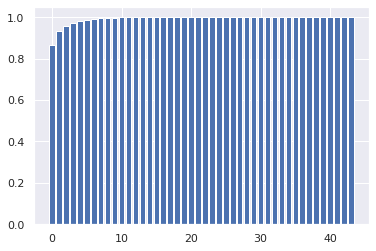

In [ ]:
plt.bar(range(44), np.cumsum(pca.explained_variance_ratio_))

First five components describie 98% of the data. Should be enough.


What are they telling us about the data set? 

<BarContainer object of 44 artists>

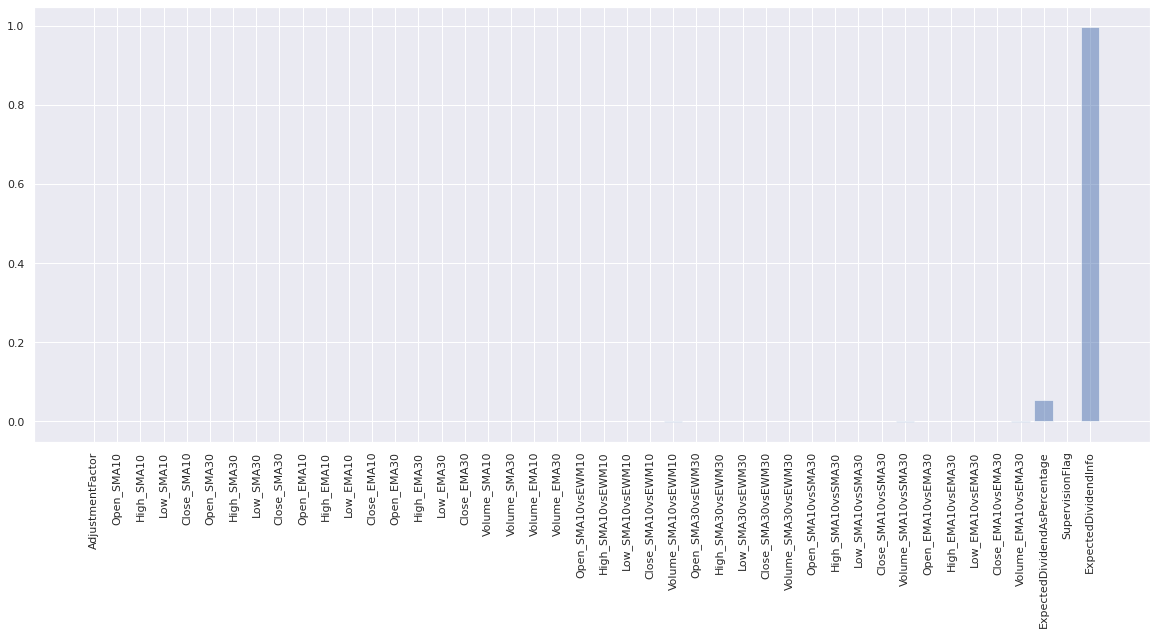

In [ ]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[0, :], label='Pattern 0', alpha=0.5)

Pattern 0: Looks like Divident is really important information!

<BarContainer object of 44 artists>

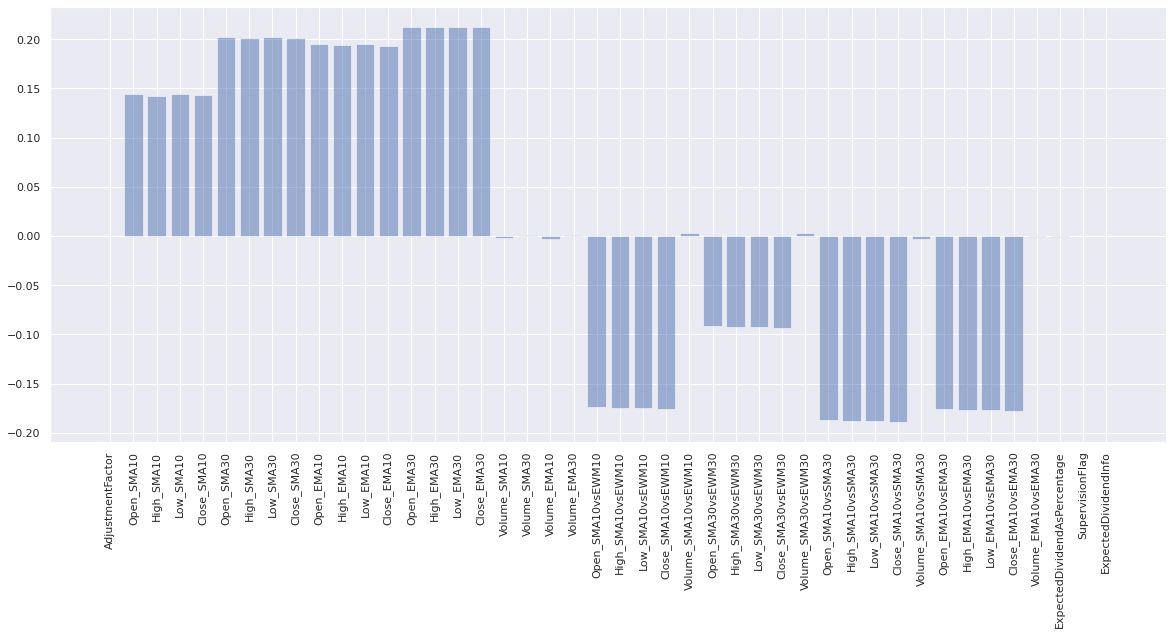

In [ ]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[1, :], label='Pattern 1', alpha=0.5)

Pattern 1: All OHLC values comes in. This are highly correlated with each other, but all ratio between them are negatively correlated. 


<BarContainer object of 44 artists>

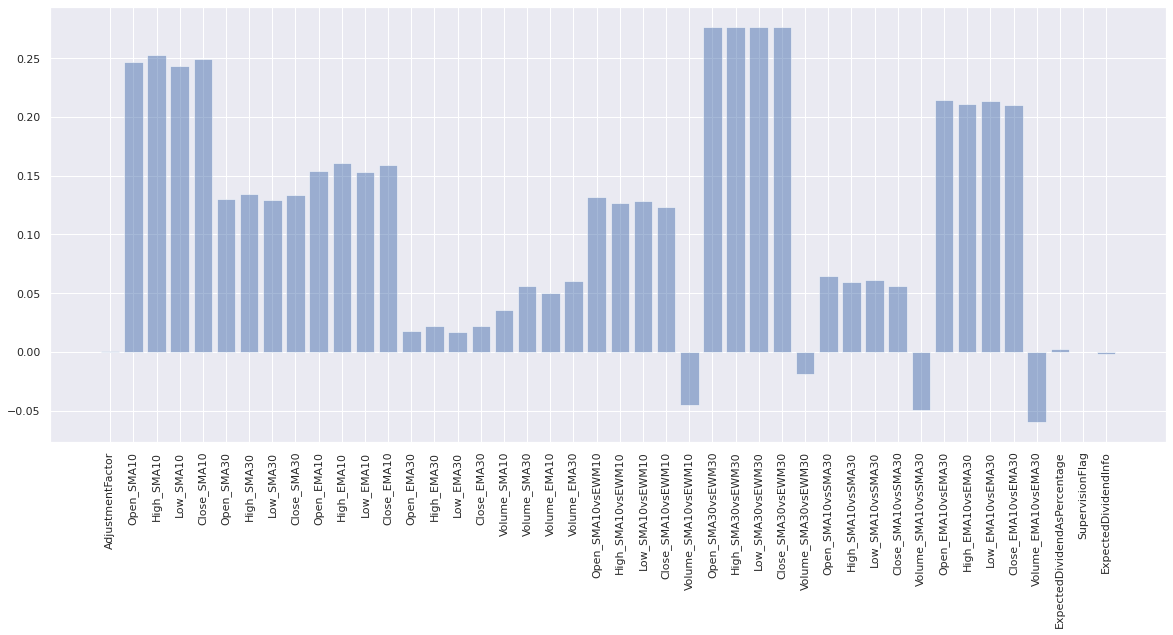

In [ ]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[2, :], label='Pattern 2', alpha=0.5)

Pattern 2: This one is much harder to decribe. It shows difference for pattern 1 (OHLC). There is a small correlation with volume as well. 

<BarContainer object of 44 artists>

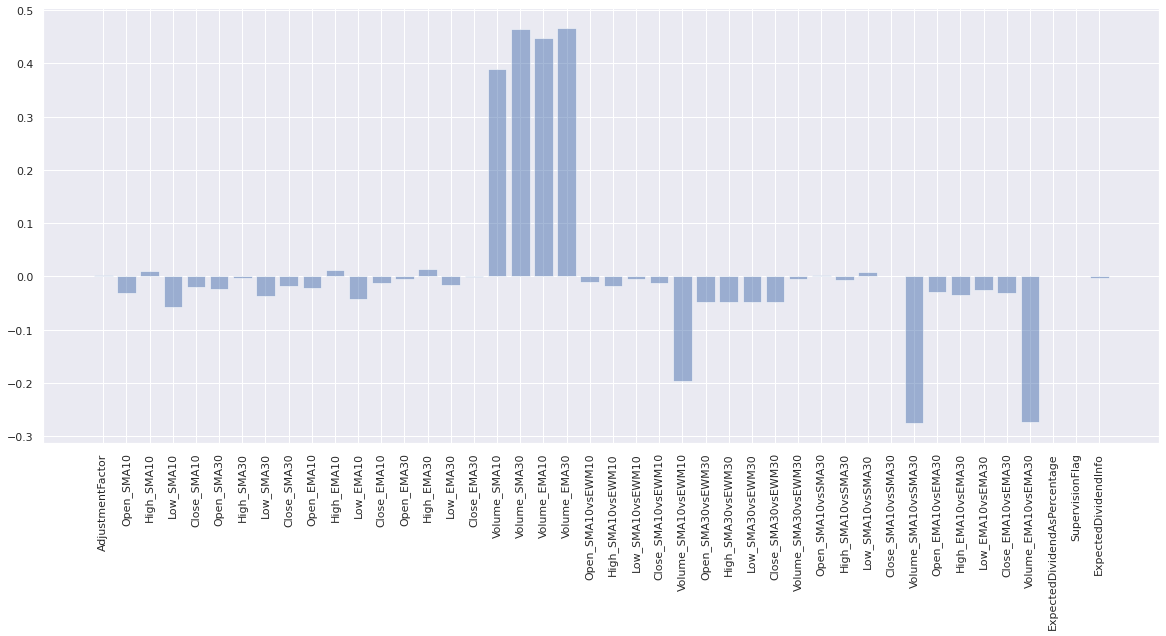

In [ ]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[3, :], label='Pattern 3', alpha=0.5)

Pattern 3: All volume features are correlated with each other - both based on SMA and EMA. There is a negative correlation with features representing ratio between small and big SMA, and small and big EMA. 

<BarContainer object of 44 artists>

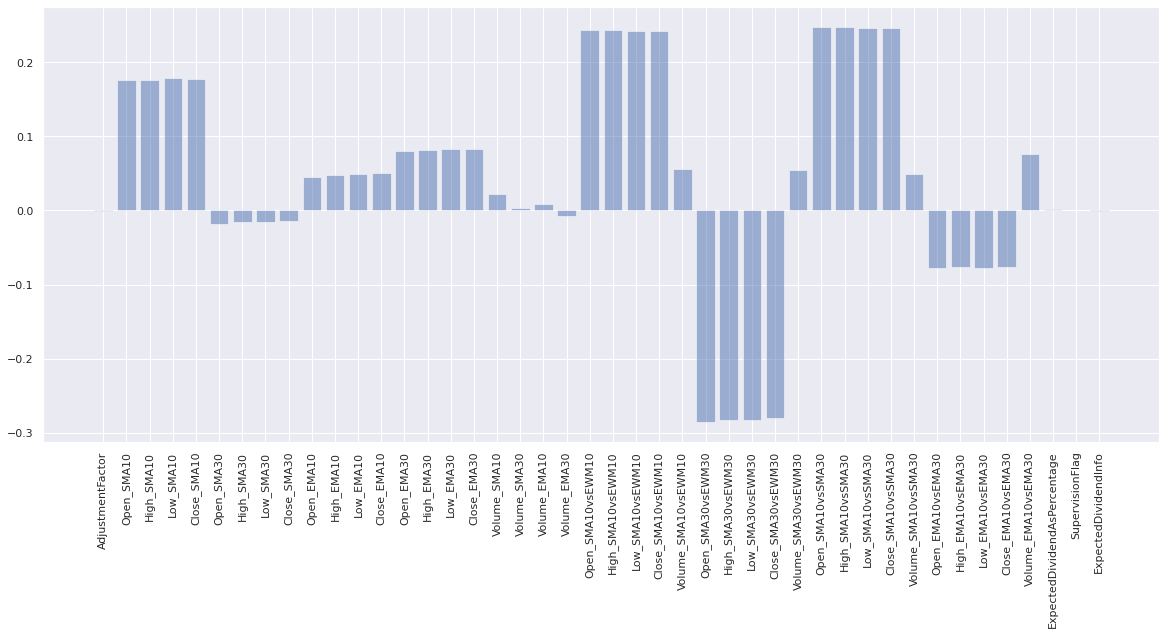

In [ ]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[4, :], label='Pattern 4', alpha=0.5)

Pattern 4: Last one is describing difference in OHLC as well.

In [ ]:
# I will take first five patterns into cosideration 
X_data = pca.transform(X_data)[:, :5]
X_data = pd.DataFrame(X_data) 
# i will create a wrapper for PCA

In [ ]:
X_data.head()

,0,1,2,3,4
0,-1.235345,0.828982,0.913894,1.749050,0.151660
1,-1.237196,0.930801,0.838084,0.961640,0.067311
2,-1.237468,0.843368,0.647860,0.866926,-0.125692
3,-1.234439,1.048199,0.835298,1.846767,-0.171161
4,-1.234129,1.284825,0.911905,1.825400,-0.246540


### 1.4 Even subsets
I'm resampling the dataset. Why now? 
- after PCA cus I don't want resampling affect component analysis 
- before splitting dataset to train and test cus I want both sets to be stratified similarly

In [ ]:
# merge X and y
X_data = X_data.join(y_data)

In [ ]:
# Let's check size of subsets 
X_data['Class'].value_counts()

None    1329849
Long     937074
Name: Class, dtype: int64

Sets are not even - we need to resample. 

In [ ]:
df_none = X_data[X_data['Class'] == 'None']
df_long= X_data[X_data['Class'] == 'Long']


# Upsample
df_long_upsampled = resample(df_long, 
                             replace=True,
                             n_samples=1300000,
                             random_state=42)
# Downsample - for now I will leave it like that
# df_none_downsampled = df_none
# resample(df_none, 
#                                replace=False,
#                                n_samples=65000,
#                                random_state=42)
 
 
# Combine majority class with upsampled minority classes
X_data = pd.concat([df_long_upsampled,
                  df_none])

In [ ]:
# # now it's better.. 
X_data['Class'].value_counts()

None    1329849
Long    1300000
Name: Class, dtype: int64

In [ ]:
y_data = X_data.pop(item='Class')

### 1.5 Encode Labels of target 
Encoding labels of class column as well..

In [ ]:
#############

### USUN TO #######

###############

test_transformer = LabelEncoder()
test_transformer.fit(y_data)
y_data = test_transformer.transform(y_data)
y_data = pd.Series(y_data)
y_data.value_counts()

1    1329849
0    1300000
dtype: int64

Label 0 is our target - go Long !!

## 2. Building a model

We're going to try to implement few models (classifiers) on this data. Let it be: 

(more simple)

- Logistic Regression 
- K-Neighbors
- Decision Tree

(more complex)

- SVN
- Naive Bayes
- Random Forest
- XGBoost

As You can see we're not going to use Neural Network. 

In [ ]:
# model listing - svn last to long, will try it separately

models = {
    'LogisticRegression':{
        'model': LogisticRegression()
    },
    'KNeighborsClassifier':{
        'model': KNeighborsClassifier()
    },
    'DecisionTreeClassifier':{
        'model': DecisionTreeClassifier()
    },
    # 'SVC':{
    #     'model': SVC()
    # },
    'GaussianNB':{
        'model': GaussianNB()
    },
    'RandomForestClassifier':{
        'model': RandomForestClassifier()
    },
    'XGBClassifier':{
        'model': XGBClassifier(tree_method='gpu_hist')
    }                        
}

### 2.1 First measurements
Let's try to fit all this models with base hyperparameters..

In [ ]:
for model_name, model_params in models.items():
  print(f'model: {model_name}')
  
  # fit
  print(f'fitting..', end=' ')
  model = model_params['model']
  %time model.fit(X_train, y_train)
  
  #predict
  print(f'predicting..', end=' ')
  %time y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  
  #measure
  print(f'accuracy: {accuracy_score(y_test, y_pred)}')
  print(f'roc_auc: {roc_auc_score(y_test, y_pred_proba)}')
  print(classification_report(y_pred, y_test))

model: LogisticRegression
fitting.. CPU times: user 5.68 s, sys: 6.35 s, total: 12 s
Wall time: 3.94 s
predicting.. CPU times: user 15.8 ms, sys: 23 ms, total: 38.8 ms
Wall time: 9.7 ms
accuracy: 0.5301766260433105
roc_auc: 0.5305555109888045
              precision    recall  f1-score   support

           0       0.36      0.54      0.43    173349
           1       0.70      0.53      0.60    352621

    accuracy                           0.53    525970
   macro avg       0.53      0.53      0.52    525970
weighted avg       0.59      0.53      0.54    525970

model: KNeighborsClassifier
fitting.. CPU times: user 3.91 s, sys: 20.4 ms, total: 3.93 s
Wall time: 3.86 s
predicting.. CPU times: user 32.3 s, sys: 506 ms, total: 32.8 s
Wall time: 32.2 s
accuracy: 0.6040933893568075
roc_auc: 0.6423473622097344
              precision    recall  f1-score   support

           0       0.64      0.59      0.62    282305
           1       0.57      0.62      0.59    243665

    accuracy       

SVN is taking really long time to compute.. 

In [ ]:
  print(f'model: SVN')
  
  # fit
  print(f'fitting..', end=' ')
  model = SVC()
  %time model.fit(X_train, y_train)
  
  #predict
  print(f'predicting..', end=' ')
  %time y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  
  #measure
  print(f'accuracy: {accuracy_score(y_test, y_pred)}')
  print(f'roc_auc: {roc_auc_score(y_test, y_pred_proba)}')
  print(classification_report(y_pred, y_test))

Well these are quite decent results :) As we can see DecisionTreeClassifier and RandomForestClassifier are good direction for us.  

- DecisionTreeClassifier are fast but results are worst (time < 1min, accu 0.72)
- RandomForestClassifier is slower but results are better (time > 20min, accu 0.78)
- SVN  - we were not able to finish this task - it takes to long

**Conclusions:** In next steps we are going to use DecisionTreeClassifier with decent results and short calculation time. It's a good start point to find clues for setting up RandomForestClassifier.. 

### 2.2 Finding right hyperparameters
What's the plan? We will do it step by step..

GridSearch or even RandomSearch for RandomForestClassifier will take to long. We will GridSearch DecisionTreeClassifier and see how it will perform. Maybe we will find some clues how to set up RandomForestClassifier.

In [ ]:
dt = DecisionTreeClassifier( )

parameters = {'criterion':['gini', 'entropy'],
              'splitter':['best', 'random'],
              'max_depth':[ 10, 20, 30], 
              'min_samples_leaf':[20, 30], 
              'min_samples_split':[2, 5],
              'max_features':['auto', 'sqrt', 'log2']}

searcher = GridSearchCV(dt, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'splitter': 'best'}
Best DC accuracy 0.5817668219076316
Test accuracy of best grid search hypers: 0.5863281175732457


This is worst than our standard parameters.. 

Similarities: 

- criterion - gini - as standard
- splitter - best - as standard 
- min_samples_split - 2 - as standard 

Differences:
- max depth - will set to None as standard
- max_features - will leave it and try again
- min_samples_leaf - will change as standard

In [ ]:
parameters = {'min_samples_split':[2, 3],
              'max_features':['auto', 'sqrt', 'log2']}

searcher = GridSearchCV(dt, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'max_features': 'log2', 'min_samples_split': 2}
Best DC accuracy 0.6893671166795274
Test accuracy of best grid search hypers: 0.7200239557389204


- min_samples_split - 2 - as standard 
- max_features - log2 - that's different than standard 

Let's check min_samples_leaf.. 

In [ ]:
dt = DecisionTreeClassifier(max_features='log2')

parameters = {'min_samples_leaf':[1, 5, 10, 20, 30]}

searcher = GridSearchCV(dt, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'min_samples_leaf': 1}
Best DC accuracy 0.6893138818227579
Test accuracy of best grid search hypers: 0.7205924292260015


min_sample_leaf should stay as standard setting.

Let's try GridSearch on RandomForestClassifier with:

- max_features set on log2 
- n_estimators 100 or 200

In [ ]:
rf = RandomForestClassifier()

parameters = {'max_features':['log2']
              'n_estimators':[100, 200]}

searcher = GridSearchCV(rf, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'n_estimators': 200}
Best DC accuracy 0.7440218755582081
Test accuracy of best grid search hypers: 0.7826948305036409


It took ages to calculate (4,5h). We should stick with this settings: 
- max_features set on log2
- n_estimators on 200 
We should try to add more estimators but have no time to do that. 

Summarizing we did some GridSearch. First on DecisionTreeClassifier because it was fast and it gave us clue for RandomForestClassifier. The clue was to use log2 to point the number of features to consider for the best split. 

Then we try GridSearch RandomForestClassifier to check number of estimators should be as standard or should be more than that (200). It last really long time to do that and effect is that we should use more.. 200 was better than 100, maybe we should use more.

But again compute power and time comes to the fore. I will stick to 100 estimators to be able to finish our attempt. 



Let's check this setup..

In [ ]:
  print(f'model: RandomForestClassifier')
  
  # fit
  print(f'fitting..', end=' ')
  model = RandomForestClassifier(n_estimators=100, max_features='log2')
  %time model.fit(X_train, y_train)
  
  #predict
  print(f'predicting..', end=' ')
  %time y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  
  #measure
  print(f'accuracy: {accuracy_score(y_test, y_pred)}')
  print(f'roc_auc: {roc_auc_score(y_test, y_pred_proba)}')
  print(classification_report(y_pred, y_test))

model: RandomForestClassifier
fitting.. CPU times: user 20min 8s, sys: 2.52 s, total: 20min 11s
Wall time: 20min 4s
predicting.. CPU times: user 33.6 s, sys: 44.8 ms, total: 33.6 s
Wall time: 33.4 s
accuracy: 0.7775063216533262
roc_auc: 0.8582436661017293
              precision    recall  f1-score   support

           0       0.77      0.78      0.77    258905
           1       0.78      0.78      0.78    267065

    accuracy                           0.78    525970
   macro avg       0.78      0.78      0.78    525970
weighted avg       0.78      0.78      0.78    525970



### 2.3 Treshold
We have our model. Now we will look after higher confidence. It's so important when you want to put your money on the market. 

In other words we need high precision (for class 0 - Long).

In [ ]:
# swapping Long to be class 1 
y_pred_proba_swap = 1-y_pred_proba
y_pred_proba_swap

array([0.78, 0.48, 0.81, ..., 0.67, 0.39, 0.36])

In [ ]:
y_test_swap = np.where(y_test==0, 1, 0)
y_test_swap 

array([1, 0, 1, ..., 0, 0, 1])

    threshold  precision    recall        F1
64       0.64   0.950891  0.692588  0.801441
    threshold  precision    recall        F1
98       0.98        1.0  0.041354  0.079423
99       0.99        1.0  0.017446  0.034294


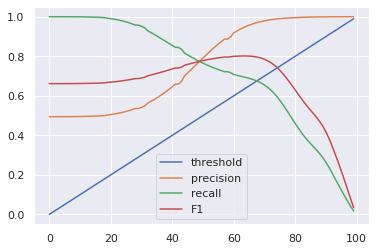

In [ ]:
def get_metrics(y_true,  y_pred_proba, thresholds = None):
    if thresholds is None:
        thresholds = np.arange(0, 1, 0.01)
    precision, recall, f1 = [], [], []
    
    for t in thresholds:
        preds = (y_pred_proba>t)
        precision.append(precision_score(y_true, preds))
        recall.append(recall_score(y_true, preds))
        f1.append(f1_score(y_true, preds))
        
    return pd.DataFrame({
        'threshold': thresholds,
        'precision': precision,
        'recall': recall,
        'F1': f1
    })
    
    
metrics = get_metrics(y_test_swap, y_pred_proba_swap)
metrics.plot()

print(metrics[metrics['F1']==metrics['F1'].max()])
print(metrics[metrics['precision']==metrics['precision'].max()])

We swap classes and I will describe situation like that. 
- if we set treshhold to 0.64 then our precision will go up to 0.95. Still there is a lot of true cases (recall = 0.69)
- if we set treshold to 0.98 then our precision will go up to 1.00! But there will be low number of true cases
- maybe we should find sth between :) 

Precision 0.95 is enough !!

In [ ]:
print(classification_report(y_test_swap, y_pred_proba_swap>0.64))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85    265970
           1       0.95      0.69      0.80    260000

    accuracy                           0.83    525970
   macro avg       0.86      0.83      0.83    525970
weighted avg       0.86      0.83      0.83    525970



In [ ]:
# unswapping 
y_pred_unswap = y_pred_proba_swap > 0.64
y_pred_unswap = np.where(y_pred_unswap==False, True, False)

In [ ]:
# classification report (Long is class 0 again)
print(classification_report(y_test, y_pred_unswap))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80    260000
           1       0.76      0.97      0.85    265970

    accuracy                           0.83    525970
   macro avg       0.86      0.83      0.83    525970
weighted avg       0.86      0.83      0.83    525970



# F. Summary and discussion

As we can see it's not an easy task to build good model for jpx trading. Dataset is quite big and we are limited by time and compute power. Anyway effects are quite decent :) 

We should run some crossvalidation to check overfitting by comparing scores between test and train datasets. 

## Are we able to compute a better model? 
Well, surprisingly yes. And it should be quite simple task. With more compute power (or time) we would be able to find better hyperparameters for  RandomForestClassifier.

Additionally we still do not know how SVN would perform (it took to long to compute) or how few ensembled SVNs would perform? 

## What else can we do? 
For modeling purposes we develop few features. We can do better in this area as well. There's a lot to add:
- OHLCV data from previous periods (now we have only means)
- OHLCV data for highier time interval
- information about trend and trend angles
- candelstick patterns
- widely used indicators like MACD, OBV, Stochastic
- zigzags 
- waves 
- and many others.. 

Doing so we will highlight other aspects of explanatory variables we have. 

## Make requirements / goal more accurate to data?
Last but not least - it is important to have right expectations about data.  Maybe we should expect less accurate results or change our target?

We can just change way we calculate class column to give our attempt more chances to achive. Ofcourse not in all situations we can do that. Now we can and we did :) 